In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airline-passenger-satisfaction/test.csv
/kaggle/input/airline-passenger-satisfaction/train.csv


# Loading and Tidying Data

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [46]:
train = pd.read_csv("/kaggle/input/airline-passenger-satisfaction/train.csv")
test = pd.read_csv("/kaggle/input/airline-passenger-satisfaction/test.csv")
train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


* We need to convert our target feature to 1's 0's 

In [47]:
train["satisfaction"].value_counts() # i checked if there is another class

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64

In [48]:
train["satisfaction"] = [1 if each == "satisfied" else 0 for each in train["satisfaction"]]
test["satisfaction"] = [1 if each == "satisfied" else 0 for each in test["satisfaction"]]

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

* Unnamed: 0 and id column wont do any good for us, so lets just drop them
* And we have no missing values. Thats nice. 
* (Later Update: Actually we do have missing values, i did not noticed till i get to the modeling part.)

In [50]:
train.drop(["Unnamed: 0","id"],axis=1,inplace = True)
test.drop(["Unnamed: 0","id"],axis=1,inplace = True)

In [51]:
#i will rename some of the long named columns
train.rename(columns = {"Inflight wifi service": "wifi",
                        "Departure/Arrival time convenient": "timeconv",
                        "Ease of Online booking": "onlinebooking",
                        "Departure Delay in Minutes": "depdel",
                        "Arrival Delay in Minutes": "arrdel"}, inplace = True)

test.rename(columns = {"Inflight wifi service": "wifi",
                        "Departure/Arrival time convenient": "timeconv",
                        "Ease of Online booking": "onlinebooking",
                        "Departure Delay in Minutes": "depdel",
                        "Arrival Delay in Minutes": "arrdel"}, inplace = True)

In [52]:
train.describe()

,Age,Flight Distance,wifi,timeconv,onlinebooking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,depdel,arrdel,satisfaction
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000,103904.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678,0.433333
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682,0.495538
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


* most columns are categorical, we have 2 numerical columns, and both seem to have some outliers. especially the departure delay feature. 
* we can just drop them because it will hurt our model but delay causes unsatisfactory (naturally) i'll decide to drop or not drop after eda.

# Exploratory Data Analysis

* first i want to look at delays, and after that i will look at other features.

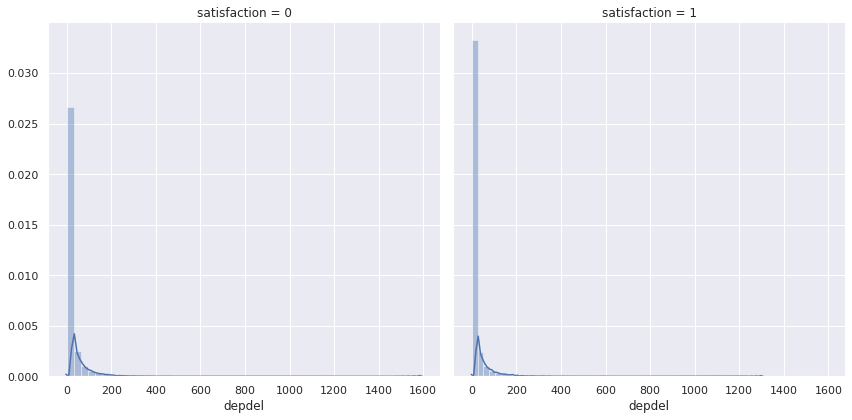

In [53]:
g = sns.FacetGrid(data = train,col = "satisfaction", height = 6)
g.map(sns.distplot, "depdel")
plt.show()

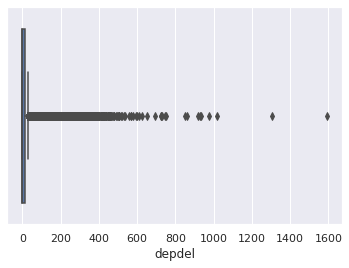

In [54]:
sns.boxplot(train["depdel"])
plt.show()

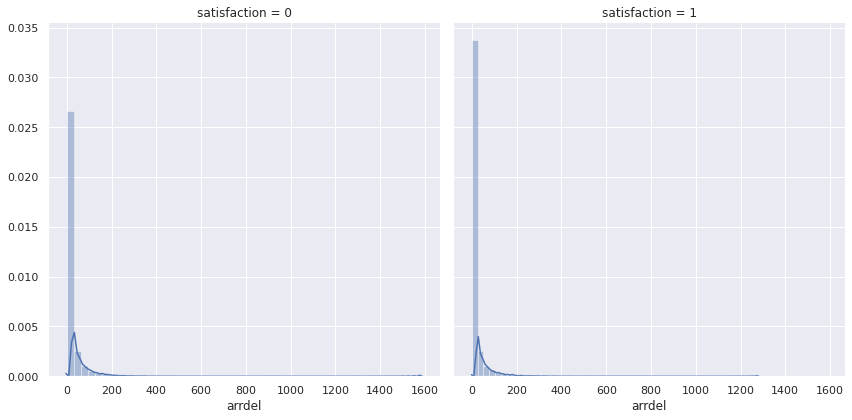

In [55]:
g = sns.FacetGrid(data = train,col = "satisfaction", height = 6)
g.map(sns.distplot, "arrdel")
plt.show()

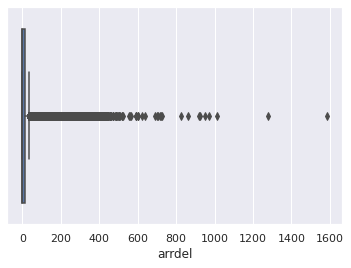

In [56]:
sns.boxplot(train["arrdel"])
plt.show()

* as expected graphs are so skewed, lets sort values and see if peoples who delayed their flights are satisfied or not.

In [57]:
train.sort_values("depdel").groupby("Customer Type").tail(10)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,wifi,timeconv,onlinebooking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,depdel,arrdel,satisfaction
89139,Male,disloyal Customer,39,Business travel,Business,668,4,4,4,1,...,5,5,4,5,5,3,5,430,438.0,1
6690,Male,disloyal Customer,36,Business travel,Eco,297,1,4,1,3,...,3,2,4,3,4,4,4,447,433.0,0
65503,Male,disloyal Customer,26,Business travel,Business,1205,5,5,5,2,...,4,4,4,4,2,3,2,452,444.0,1
23055,Male,disloyal Customer,25,Business travel,Eco,86,1,1,1,4,...,3,2,3,3,5,4,5,459,445.0,0
63113,Male,disloyal Customer,26,Business travel,Eco,424,1,2,1,4,...,2,3,3,4,5,2,5,491,485.0,0
86902,Male,disloyal Customer,22,Business travel,Eco,288,2,1,2,3,...,3,5,3,3,3,4,3,503,484.0,0
10837,Female,disloyal Customer,20,Business travel,Eco,641,5,0,5,5,...,4,5,3,1,5,5,5,505,486.0,1
12745,Male,disloyal Customer,38,Business travel,Eco,944,3,3,3,2,...,3,1,2,4,1,1,1,566,600.0,0
8161,Female,disloyal Customer,39,Business travel,Eco,685,3,3,3,3,...,5,3,1,5,4,1,4,652,638.0,0
66737,Female,Loyal Customer,30,Business travel,Business,2475,2,1,3,1,...,4,2,4,4,2,1,2,748,720.0,0


* seems like we dont have a bias in long delay times, so we can drop those outliers in order to help our modeling.

In [58]:
Q3 = np.quantile(train["depdel"],0.75)
Q1 = np.quantile(train["depdel"],0.25)

IQR = Q3 - Q1

step = IQR * 3

maxm = Q3 + step
minm = Q3 - step

train = train[train["depdel"] < maxm]

* Now even if i visualize the delay times again it will look skewed, because most of our flights are took place with 0 delay (like half of all data). 

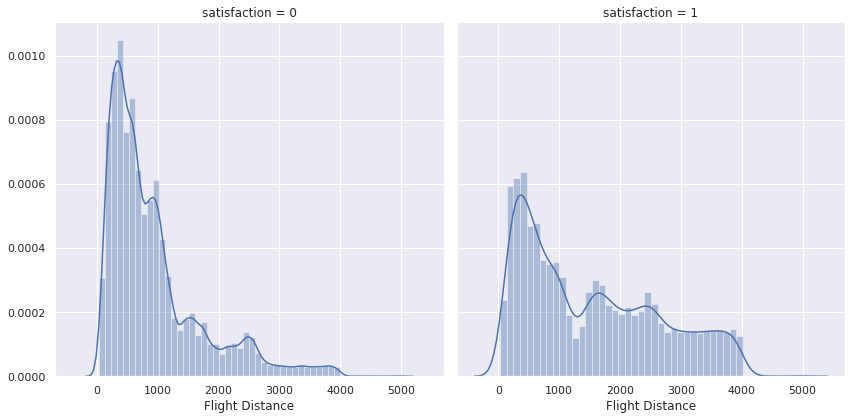

In [59]:
g = sns.FacetGrid(data = train,col = "satisfaction", height = 6)
g.map(sns.distplot, "Flight Distance")
plt.show()

* It seems that if flight distance increases satisfaction is going up.

In [60]:
cat_cols = ["Gender","Customer Type","Type of Travel","Class","wifi","timeconv","onlinebooking","Gate location","Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service","Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness"]

In [61]:
def ctgplt(df,variable,to):
    
    "Function for visualization of categorical variables."
    
    var = df[variable]
    values=var.value_counts()
    
    f, ax = plt.subplots(figsize = (8,8))
    sns.countplot(x = variable, hue = to, data = df)
    
    plt.show()
    
    print("{}:\n{}".format(variable,values))

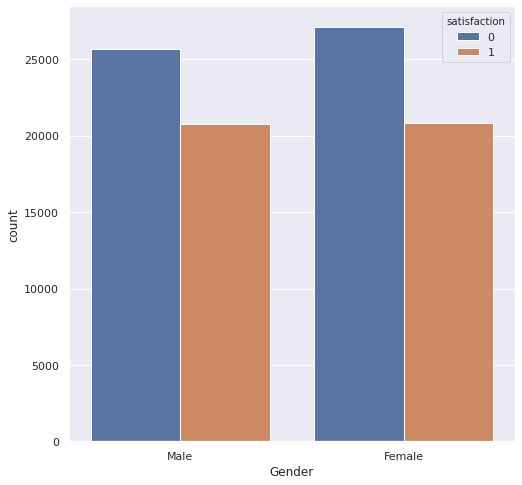

Gender:
Female    47923
Male      46463
Name: Gender, dtype: int64


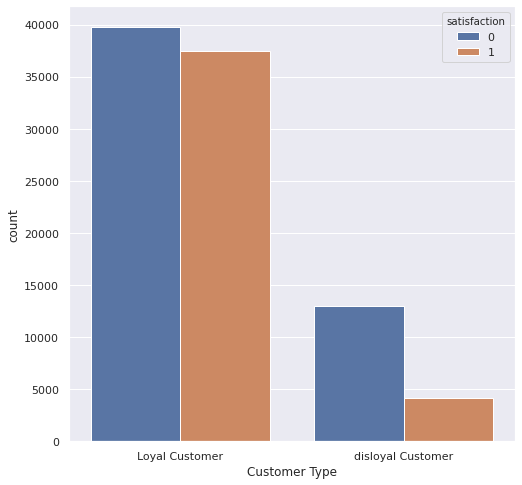

Customer Type:
Loyal Customer       77201
disloyal Customer    17185
Name: Customer Type, dtype: int64


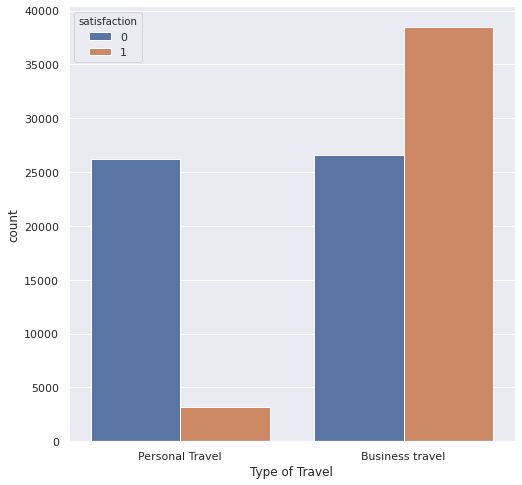

Type of Travel:
Business travel    65015
Personal Travel    29371
Name: Type of Travel, dtype: int64


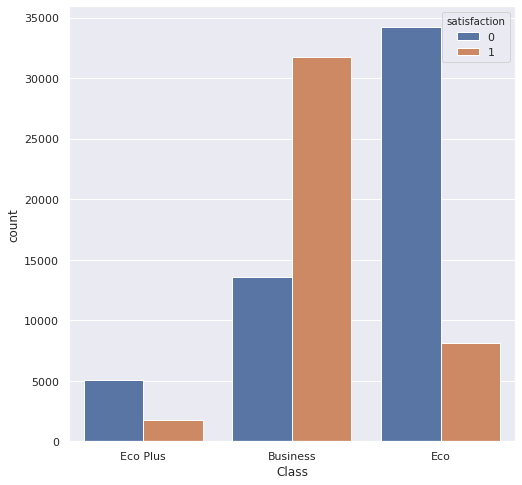

Class:
Business    45297
Eco         42332
Eco Plus     6757
Name: Class, dtype: int64


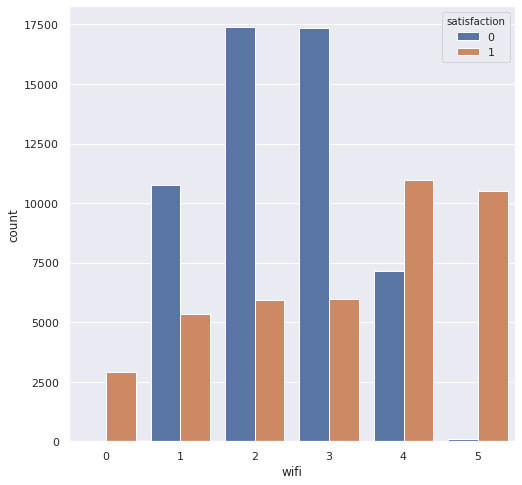

wifi:
3    23339
2    23298
4    18136
1    16117
5    10598
0     2898
Name: wifi, dtype: int64


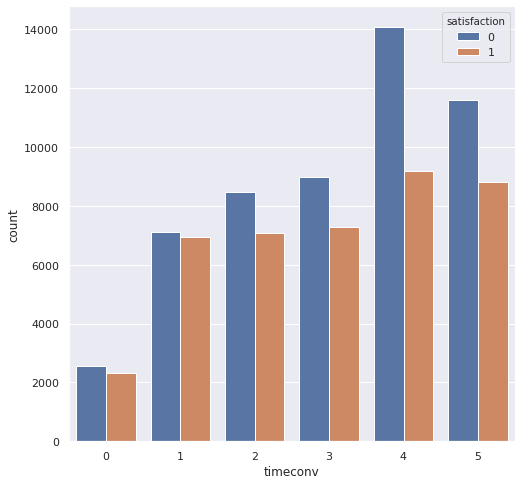

timeconv:
4    23258
5    20399
3    16247
2    15541
1    14049
0     4892
Name: timeconv, dtype: int64


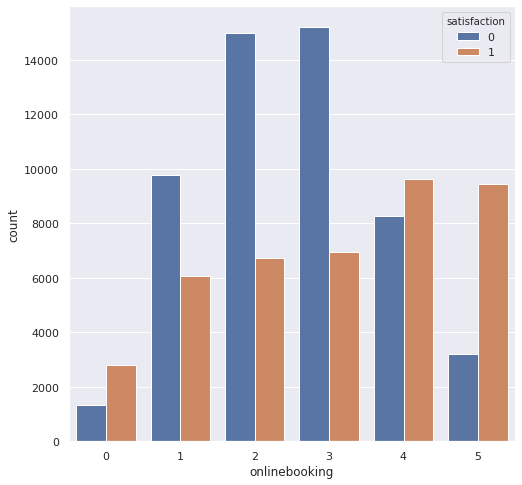

onlinebooking:
3    22168
2    21704
4    17894
1    15868
5    12621
0     4131
Name: onlinebooking, dtype: int64


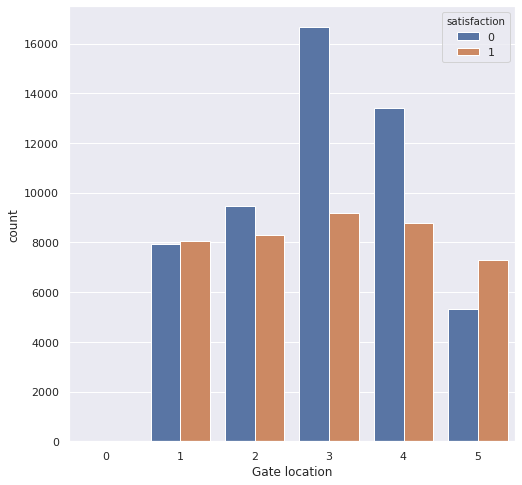

Gate location:
3    25855
4    22157
2    17754
1    15995
5    12624
0        1
Name: Gate location, dtype: int64


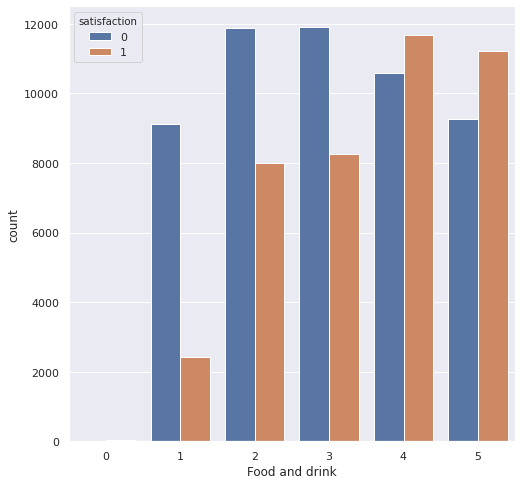

Food and drink:
4    22268
5    20478
3    20171
2    19876
1    11549
0       44
Name: Food and drink, dtype: int64


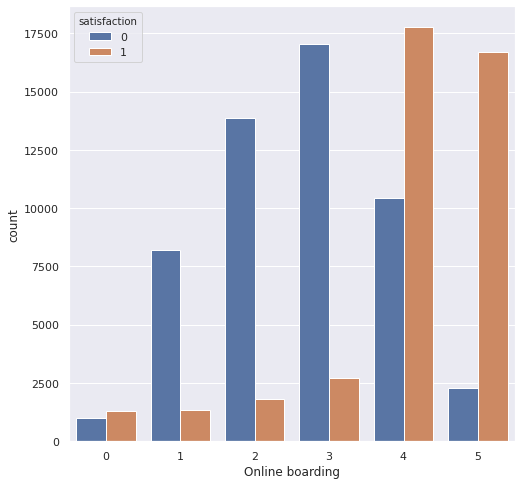

Online boarding:
4    28209
3    19716
5    18939
2    15701
1     9545
0     2276
Name: Online boarding, dtype: int64


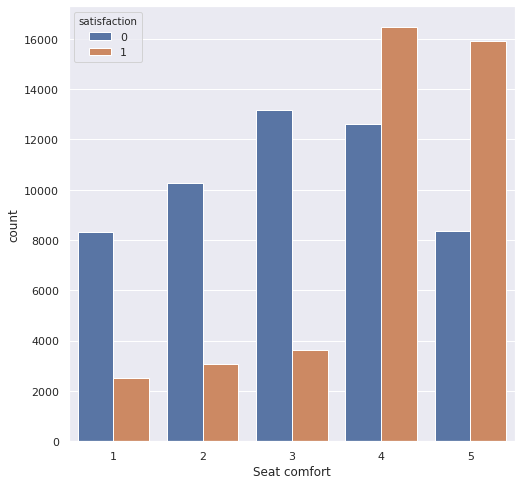

Seat comfort:
4    29087
5    24271
3    16814
2    13368
1    10846
Name: Seat comfort, dtype: int64


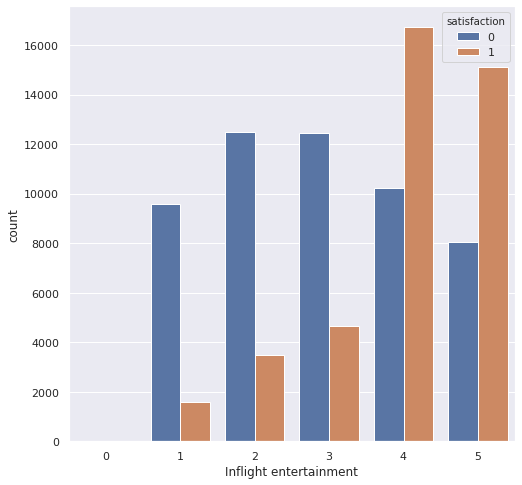

Inflight entertainment:
4    26954
5    23152
3    17114
2    15958
1    11194
0       14
Name: Inflight entertainment, dtype: int64


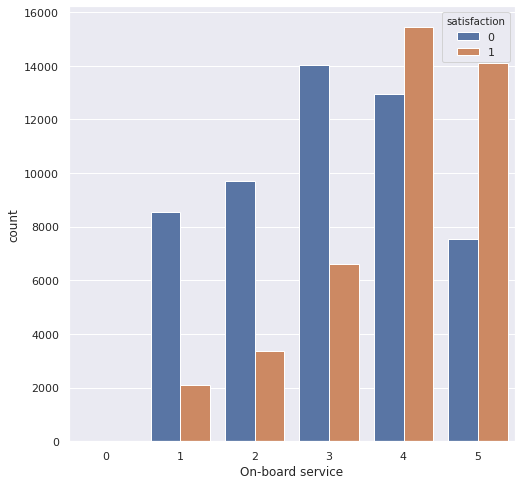

On-board service:
4    28376
5    21654
3    20634
2    13058
1    10661
0        3
Name: On-board service, dtype: int64


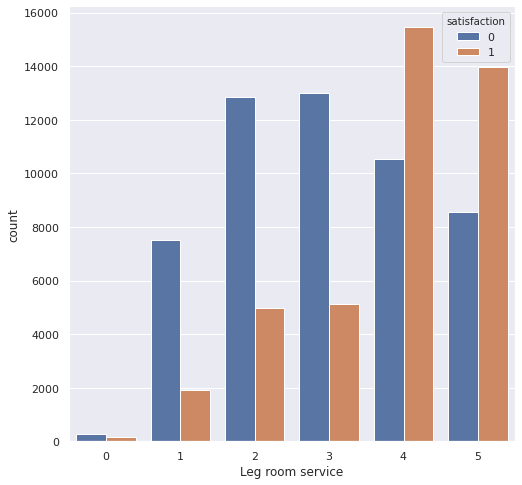

Leg room service:
4    26014
5    22525
3    18125
2    17844
1     9432
0      446
Name: Leg room service, dtype: int64


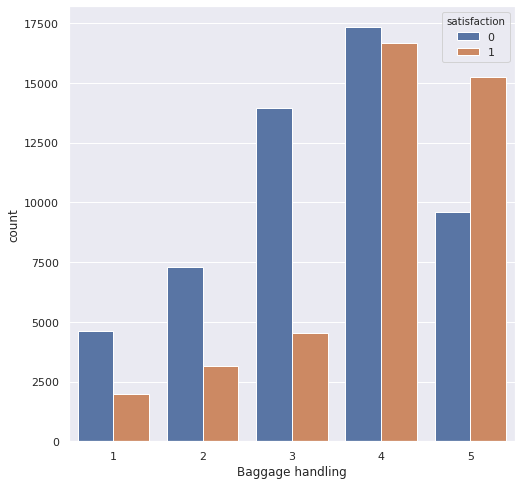

Baggage handling:
4    33996
5    24858
3    18488
2    10443
1     6601
Name: Baggage handling, dtype: int64


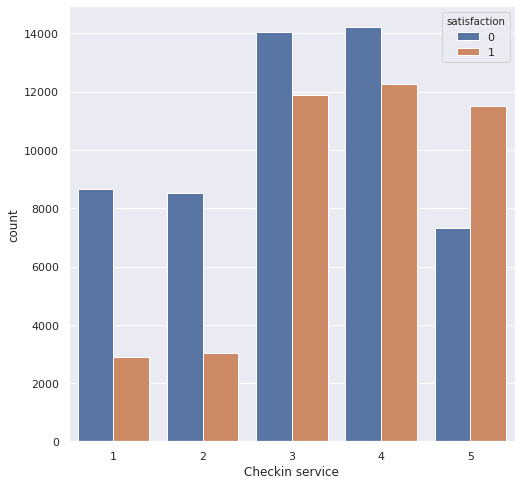

Checkin service:
4    26491
3    25952
5    18830
1    11565
2    11548
Name: Checkin service, dtype: int64


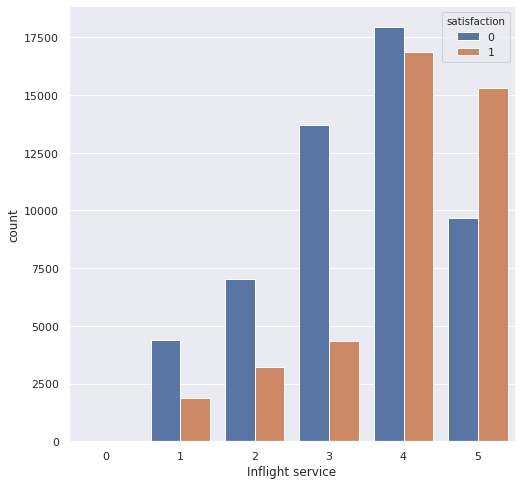

Inflight service:
4    34805
5    24998
3    18062
2    10254
1     6264
0        3
Name: Inflight service, dtype: int64


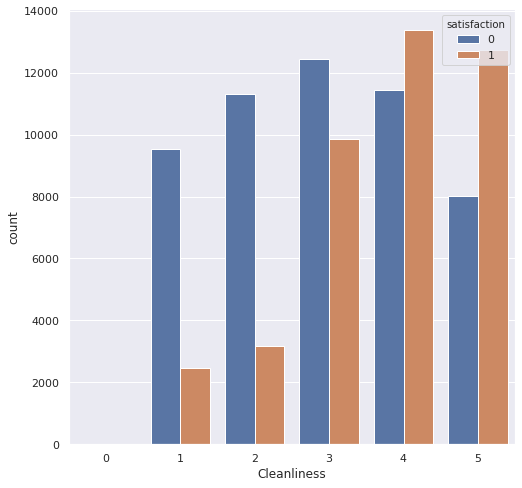

Cleanliness:
4    24808
3    22314
5    20747
2    14506
1    12000
0       11
Name: Cleanliness, dtype: int64


In [62]:
for i in cat_cols:
    ctgplt(train, i, "satisfaction")

* As i expected disyoal customers are not satisfied at all
* People who are going to a personal travel are probably flying in eco class and thats why their satisfaction is so low. i will visualize this to confirm
* Most people in business class are satisfied compared to other classes
* Most people are complaint in wifi levels 1-2-3, but in 0 and 5 almost no complain at all. That is some weird statistics.
* Time conv. satisfactions are almost equal to each other except 1 class.
* Online booking have some negative impact on satisfaction
* Gate location have same impact too. if airport is too big it is really exhaustive to get to the gate
* Food and drink is as expected
* Online boarding has some serious impact on low classes
* Seat comfort has some negativity but also has some positive impact too
* Peoples have some complaint on flight entertainment.
* On board, leg room, inflight services and Cleanliness almost have the same distribution. like many features


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:335: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


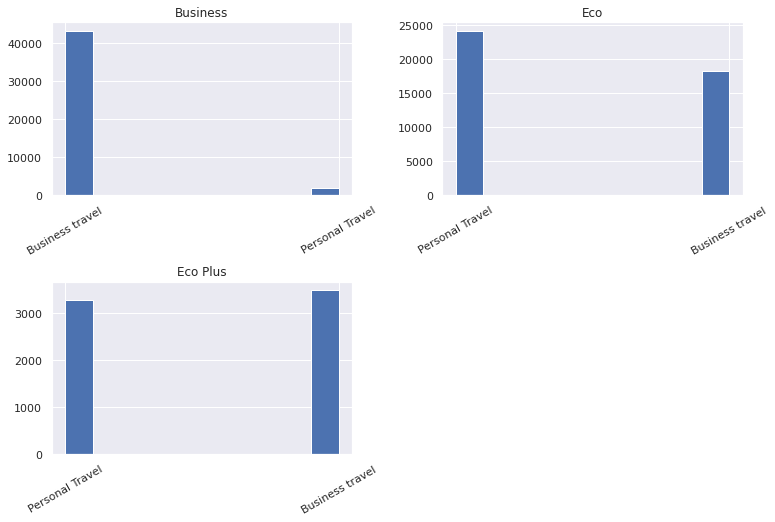

In [63]:
f, ax = plt.subplots(figsize = (12,8))
train["Type of Travel"].hist(by = train["Class"],xrot =30,ax=ax)
plt.show()

* We can see that most of the travels in eco class are personal travels.
* And dissatisfactory on the business travels are also coming from eco class. 

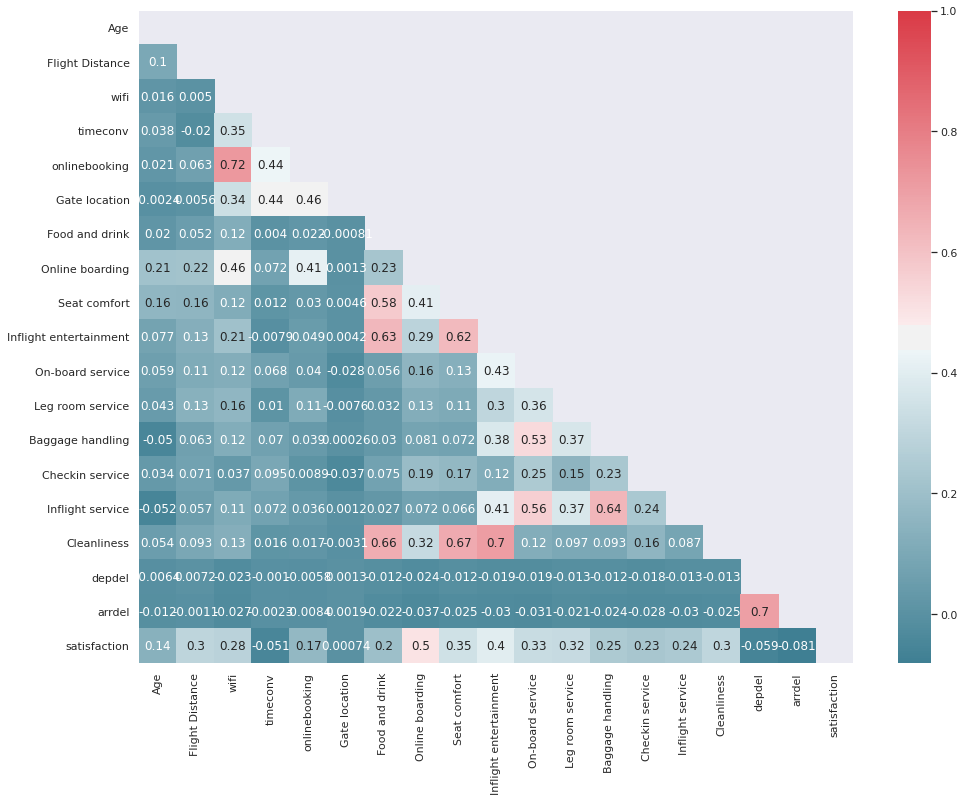

In [64]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(16, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, ax=ax)
plt.show()

* we can see that arrdel and depdel are highly correlated and they are not correlated with our target. so we can drop them.
* Also gate location is not related with our target feature, i will drop that too.

In [65]:
train.drop(["arrdel","depdel","Gate location"],axis=1,inplace=True)
test.drop(["arrdel","depdel","Gate location"],axis=1,inplace=True)

# Modeling

In [66]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [67]:
labelenc = ["Gender","Customer Type","Type of Travel","Class"]
scal = []
for each in train.columns:
    if train[each].dtype == "int64" or train[each].dtype == "float64":
        scal.append(each)

le = LabelEncoder()
scaler = MinMaxScaler()

# Label Encoder
for each in labelenc:
    train[each] = le.fit_transform(train[each])
    test[each] = le.transform(test[each])

# MinMax Scaler
train[train.columns] = scaler.fit_transform(train[train.columns])
test[test.columns] = scaler.transform(test[test.columns])

In [68]:
train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,wifi,timeconv,onlinebooking,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,1.0,0.0,0.076923,1.0,1.0,0.086632,0.6,0.8,0.6,1.0,0.6,1.00,1.0,0.8,0.6,0.75,0.75,1.0,1.0,0.0
1,1.0,1.0,0.230769,0.0,0.0,0.041195,0.6,0.4,0.6,0.2,0.6,0.00,0.2,0.2,1.0,0.50,0.00,0.8,0.2,0.0
2,0.0,0.0,0.243590,0.0,0.0,0.224354,0.4,0.4,0.4,1.0,1.0,1.00,1.0,0.8,0.6,0.75,0.75,0.8,1.0,1.0
3,0.0,0.0,0.230769,0.0,0.0,0.107229,0.4,1.0,1.0,0.4,0.4,0.25,0.4,0.4,1.0,0.50,0.00,0.8,0.4,0.0
4,1.0,0.0,0.692308,0.0,0.0,0.036955,0.6,0.6,0.6,0.8,1.0,1.00,0.6,0.6,0.8,0.75,0.50,0.6,0.6,1.0


In [69]:
X = train.drop("satisfaction",axis=1)
y = train["satisfaction"]

X_test = test.drop("satisfaction",axis=1)
y_test = test["satisfaction"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
xg = XGBClassifier(n_estimators = 300,max_depth = 3)

xg.fit(X_train, y_train)

print("train score: ", xg.score(X_train, y_train))
print("vald score: ", xg.score(X_val, y_val))

preds = xg.predict(X_test)

print("test score",accuracy_score(y_test,preds))
print("roc-auc",roc_auc_score(y_test,preds))

train score:  0.9662479188739216
vald score:  0.9581155530442153
test score 0.960232522328303
roc-auc 0.9580813842227044


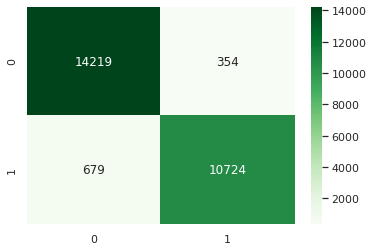

In [71]:
cf_matrix = confusion_matrix(y_test, preds)
sns.heatmap(cf_matrix,annot = True, fmt="g",cmap="Greens")
plt.show()

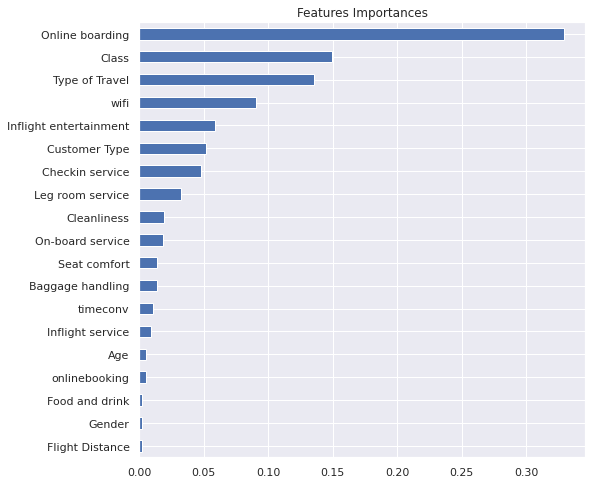

In [72]:
importances = pd.Series(data=xg.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize=(8,8))
importances_sorted.plot(kind='barh')
plt.title('Features Importances')
plt.show()

In [73]:
lg=LGBMClassifier(max_depth = 7, n_estimators = 250,n_jobs=-1)

lg.fit(X_train,y_train)

print("train score: ", lg.score(X_train, y_train))
print("vald score: ", lg.score(X_val, y_val))

preds = lg.predict(X_test)

print("test score",accuracy_score(y_test,preds))
print("roc-auc",roc_auc_score(y_test,preds))


train score:  0.9751021643711215
vald score:  0.9610820737392287
test score 0.9636202648598706
roc-auc 0.9613009662368709


* We can see that lightgbm gave us a better result

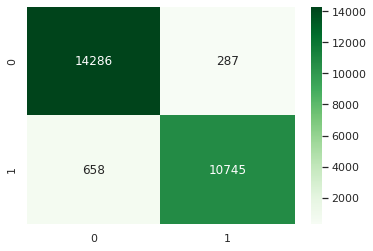

In [74]:
cf_matrix = confusion_matrix(y_test, preds)
sns.heatmap(cf_matrix,annot = True, fmt="g",cmap="Greens")
plt.show()

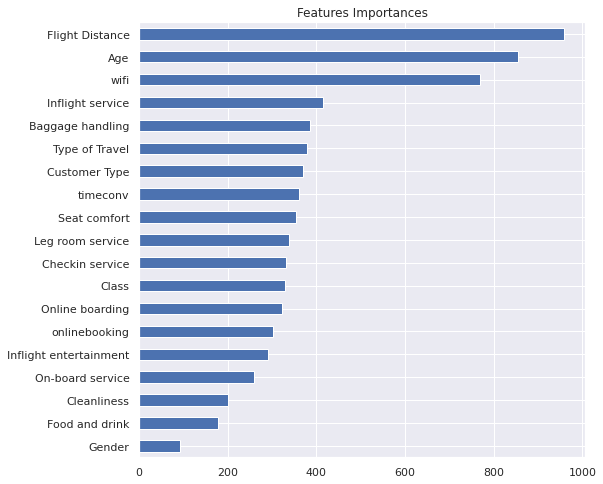

In [75]:
importances = pd.Series(data=lg.feature_importances_,
                        index= X_train.columns)

importances_sorted = importances.sort_values()
plt.figure(figsize=(8,8))
importances_sorted.plot(kind='barh')
plt.title('Features Importances')
plt.show()

* now i will select first 10 features and fit the model again lets see if our score will improve or not

In [76]:
X_train_selected = X_train[["Leg room service","Seat comfort","timeconv","Customer Type","Type of Travel","Baggage handling","Inflight service","wifi","Age","Flight Distance"]]
X_val_selected = X_val[["Leg room service","Seat comfort","timeconv","Customer Type","Type of Travel","Baggage handling","Inflight service","wifi","Age","Flight Distance"]]
X_test_selected = X_test[["Leg room service","Seat comfort","timeconv","Customer Type","Type of Travel","Baggage handling","Inflight service","wifi","Age","Flight Distance"]]

lg2 = LGBMClassifier(max_depth=5, n_estimators=150, n_jobs=-1)

lg2.fit(X_train_selected, y_train)

print("train score: ", lg2.score(X_train_selected, y_train))
print("vald score: ", lg2.score(X_val_selected, y_val))

preds = lg2.predict(X_test_selected)

print("test score",accuracy_score(y_test,preds))
print("roc-auc",roc_auc_score(y_test,preds))

train score:  0.95032541244135
vald score:  0.9457903658708857
test score 0.9474129966122574
roc-auc 0.9447676049861352


* As expected, it did not. But our runtime is now shorter, if we tune the hyperparameters we could get a better accuracy. But i will not do that now cause it takes time. Why dont you do give it a try?

### **Thank you for reading, I hope you like it. See you in another notebook.**